<a href="https://colab.research.google.com/github/SondipPoulSingh/Deep-Learning/blob/main/Hyper_Parameter_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database
df = pd.read_csv("/content/diabetes.csv") 
df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
df.shape

(768, 9)

In [ ]:
df.corr()['Outcome']

Pregnancies                 0.221898
Glucose                     0.466581
BloodPressure               0.065068
SkinThickness               0.074752
Insulin                     0.130548
BMI                         0.292695
DiabetesPedigreeFunction    0.173844
Age                         0.238356
Outcome                     1.000000
Name: Outcome, dtype: float64

In [ ]:
df = df.drop(['BloodPressure','SkinThickness'], axis=1) # low correlation
df.head()

,Pregnancies,Glucose,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,0,33.6,0.627,50,1
1,1,85,0,26.6,0.351,31,0
2,8,183,0,23.3,0.672,32,1
3,1,89,94,28.1,0.167,21,0
4,0,137,168,43.1,2.288,33,1


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
X = df.iloc[:,:-1].values # all row, all col except last -1
y = df.iloc[:,-1]



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,
                                                    random_state=83)
X_train.shape, X_test.shape

((614, 6), (154, 6))

In [ ]:
X_train[0]

array([  1.   , 109.   , 182.   ,  25.4  ,   0.947,  21.   ])

In [ ]:
X_train.mean(),X_train.std()

(1.086837219329035e-15, 1.0000000000000002)

In [ ]:
X_train[:,0].mean(), X_train[:,0].std()

(3.785016286644951, 3.339532762437881)

In [ ]:
# scaling 
scalar = StandardScaler() # mean 0 Std 1
X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)

In [ ]:
(1-3.785016286644951)/3.339532762437881

-0.8339538746168403

In [ ]:
X_train[0]

array([-0.83395387, -0.37501863,  0.8537149 , -0.89941793,  1.38016497,
       -1.03460352])

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

In [ ]:
# Building a normal model
model = Sequential()
model.add(Dense(units=32, activation='relu', input_dim=6))
model.add(Dense(units=1,activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 32)                224       
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 257
Trainable params: 257
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train,y_train, epochs=10, 
                    validation_data=(X_test,y_test),
                    verbose = 0)

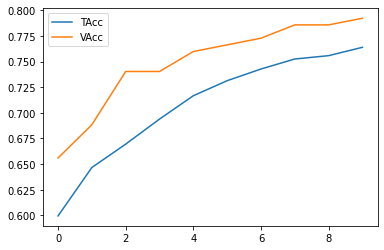

In [ ]:
#plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'],label='TAcc')
#plt.plot(history.history['val_loss'])
plt.plot(history.history['val_accuracy'],label='VAcc')
plt.legend()
plt.show()

#### Using Keras Tuner

In [ ]:
# Changing the hyperparameters each time is cumbersome
# Hyperparameters - lr, epochs, layer, neuron in layer, loss, optimizer
# Keras tuner provides handy ways to find the best model with hyperparameters
# We need only 3 things 
      #1 A function to define the keras model
      #2 A keras tuner object 
      # A search method from tuner 
      # from https://keras.io/keras_tuner/

#### First i will try to find the neuron number for first layer
##### https://keras.io/guides/keras_tuner/getting_started/
##### https://keras.io/api/keras_tuner/hyperparameters/

In [ ]:
def build_model(hp):
  model = Sequential()
  model.add(Dense(units=hp.Int("units",min_value=32,max_value=512, step=32),
                  activation='relu', input_dim=6))
  model.add(Dense(units=1,activation='sigmoid'))

  model.compile(
        optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
  return model


In [ ]:
#pip install keras-tuner --upgrade

In [ ]:
import keras_tuner

In [ ]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=16,
    directory="my_dir4",
    project_name="first_layer",
)

In [ ]:
#tuner.search_space_summary()
tuner.search(X_train,y_train, epochs=100,
             validation_data=(X_test, y_test))

Trial 2 Complete [00h 00m 22s]
val_accuracy: 0.8246753215789795

Best val_accuracy So Far: 0.8311688303947449
Total elapsed time: 00h 00m 43s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
64                |256               |units

Epoch 1/100
20/20 [==============================] - 2s 27ms/step - loss: 0.6525 - accuracy: 0.6303 - val_loss: 0.6351 - val_accuracy: 0.6299
Epoch 2/100
20/20 [==============================] - 0s 8ms/step - loss: 0.5945 - accuracy: 0.6824 - val_loss: 0.5806 - val_accuracy: 0.6818
Epoch 3/100
20/20 [==============================] - 0s 10ms/step - loss: 0.5571 - accuracy: 0.7199 - val_loss: 0.5409 - val_accuracy: 0.6883
Epoch 4/100
20/20 [==============================] - 0s 12ms/step - loss: 0.5316 - accuracy: 0.7362 - val_loss: 0.5137 - val_accuracy: 0.7208
Epoch 5/100
20/20 [==============================] - 0s 12ms/step - loss: 0.5143 - accuracy: 0.7443 - val_loss: 0.4933 - val_accuracy: 0.7532
Epoch 6/100
20/20 [=====

KeyboardInterrupt: ignored

In [ ]:
models=tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

In [ ]:
# to see all the results summary at each trail
tuner.results_summary() 

#### Now lets add the learning rate and activation tuner

In [ ]:
def build_model(hp):
  model = Sequential()
  model.add(Dense(units=hp.Int("units",min_value=32,max_value=512, step=32),
                  activation='relu', input_dim=6))
  model.add(Dense(units=1,activation='sigmoid'))
  
  learning_rates = hp.Float("lr",min_value=1e-4, max_value=1e-2,sampling="log")
  model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rates), 
        loss="binary_crossentropy", metrics=["accuracy"])
  return model

In [ ]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=5,
    directory="my_dir5",
    project_name="first_layer",
)

In [ ]:
tuner.search(X_train,y_train,epochs=100,validation_data=(X_test,y_test))

In [ ]:
tuner.results_summary()

In [ ]:
models = tuner.get_best_models(num_models=3)
best_model = models[0]
best_model.summary()

In [ ]:
#https://stackoverflow.com/questions/72373595/keras-tuner-get-best-hyperparameters
best_hp = tuner.get_best_hyperparameters()[0]
best_hp.values

##### Adding hp.choice for optimizer, activation, loss


In [ ]:
def build_model(hp):
  model = Sequential()
  model.add(Dense(units=hp.Int("units",min_value=16,
                               max_value=512, step=32),
                               input_dim=X.shape[1], activation='relu'))
  model.add(Dense(units=32,activation=hp.Choice("activations",["relu","tanh"])))
  model.add(Dense(1,activation='sigmoid'))

  model.compile(optimizer=hp.Choice("optimizers",values=["sgd","adam",'rmsprop']),
                loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
tuner = keras_tuner.RandomSearch(
                    hypermodel=build_model,
                    objective='val_accuracy',
                    max_trials=10,
                    directory='Day2',
                    project_name='multiple_tuner')

In [ ]:
tuner.search(X_train,y_train,epochs=10,validation_data=(X_test,y_test))

In [ ]:
tuner.results_summary()

In [ ]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

In [ ]:
best_hp = tuner.get_best_hyperparameters()[0]
best_hp.values

##### Tuning number of layers and neuron number in each layer is tricky. cause the number of layer and neurons in each layer is connected. And the numbers are not fixed. Changing layer or neuron changes the whole structure. And for each different new structure we need different names. Keras solves this using looping convention.

In [ ]:
def build_model(hp):
  model = Sequential()
  model.add(Dense(units=hp.Int("units",min_value=8,
                               max_value=64, step=32),
                               input_dim=X.shape[1], activation='relu'))
  for i in range(hp.Int("num_layers", 1, 3)):
        model.add(
                 Dense(
                      # Tune number of units separately.
                      units=hp.Int(f"units_{i}", min_value=16, max_value=32, step=10),
                      activation=hp.Choice("activation", ["relu", "tanh"]),
                  )
                )
  #model.add(Dense(units=32,activation=hp.Choice("activations",["relu","tanh"])))
  #https://keras.io/guides/keras_tuner/getting_started/
  if hp.Boolean("dropout"):
        model.add(keras.layers.Dropout(rate=0.20))
  model.add(Dense(1,activation='sigmoid'))

  model.compile(optimizer=hp.Choice("optimizers",values=["sgd","adam",'rmsprop']),
                loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
tuner = keras_tuner.RandomSearch(
                    hypermodel=build_model,
                    objective='val_accuracy',
                    max_trials=20,
                    directory='Day9',
                    project_name='multiple_tuner')

In [ ]:
tuner.search(X_train,y_train,epochs=20,validation_data=(X_test,y_test))

In [ ]:
best_hp = tuner.get_best_hyperparameters()[0]
best_hp.values

In [ ]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

In [ ]:
history = best_model.fit(X_train,y_train,epochs=20,validation_data=(X_test,y_test))

In [ ]:
plt.plot(history.history['accuracy'],label='TAcc')
plt.plot(history.history['val_accuracy'],label='VAcc')
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history['loss'],label='training_loss')
plt.plot(history.history['val_loss'],label='testing_loss')
plt.legend()
plt.show()

In [ ]:
y_pred = best_model.predict(X_test)
y_pred = np.where(y_pred>=0.5,1,0)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

In [ ]:
best_model.save('First_Hypertuned_Model')

In [ ]:
# importing saved model
reconstructed_model = keras.models.load_model("First_Hypertuned_Model")
reconstructed_model.summary()

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
                                            #restore_best_weights=True)

history = best_model.fit(X_train,y_train,epochs=20,
                         validation_data=(X_test,y_test),callbacks=[callback])
plt.plot(history.history['accuracy'],label='TAcc')
plt.plot(history.history['val_accuracy'],label='VAcc')
plt.legend()
plt.show()

In [ ]:
weights = best_model.get_weights()
prev = weights[0][0]

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5,
                                            restore_best_weights=True)

history = best_model.fit(X_train,y_train,epochs=20,
                         validation_data=(X_test,y_test),callbacks=[callback])
plt.plot(history.history['accuracy'],label='TAcc')
plt.plot(history.history['val_accuracy'],label='VAcc')
plt.legend()
plt.show()

In [ ]:
weights = best_model.get_weights()
later = weights[0][0]
print(prev,'\n',later)

### Let test our trained model in another random regression dataset

In [ ]:
model = keras.models.load_model("First_Hypertuned_Model")

In [ ]:
model.summary()

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
# https://queirozf.com/entries/scikit-learn-examples-making-dummy-dataset
X,y = make_classification(n_samples=1000,
                n_features=6,n_informative=2,
                random_state=83,class_sep=0.8)

In [ ]:
X[0:5],y[0:5]

In [ ]:
X.mean(), X.std() # results shows the data is normalized

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,
                                                    random_state=83)

In [ ]:
X_train.shape, X_test.shape

In [ ]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)

In [ ]:
X_train.mean(), X_train.std() # results shows the data is normalized

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='loss',patience=5,restore_best_weights=True)
history = model.fit(X_train,y_train, epochs=100,
                    validation_data=(X_test,y_test),verbose=0,
                    callbacks=[callback])
plt.plot(history.history['accuracy'],label='TAcc')
plt.plot(history.history['val_accuracy'],label='VAcc')
plt.legend()
plt.show()

#### using k-fold cross validation with the model

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
# https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-keras.md

In [ ]:
# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X, y):
  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = model.fit(X[train], y[train],
              epochs=10,
              verbose=0)

  # Generate generalization metrics
  scores = model.evaluate(X[test], y[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  #acc_per_fold.append(scores[1] * 100)
  #loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1